# IMPORTING THE LIBRARIES

In [9]:
import sys
print(sys.version)


3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


In [10]:
!pip install opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# IMPORTING THE LIBRARIES
import os
from pathlib import Path
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import secrets
import cv2
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.datasets import load_files

# Use tensorflow.keras consistently (works with TF 2.15+ / Keras 3.x)
import tensorflow as tf
from tensorflow.keras.utils import to_categorical  # replacement for np_utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# Defining the train,test and model directories

We will create the directories for train,test and model training paths if not present

In [14]:
BASE_DIR = "."
TRAIN_DIR = f"{BASE_DIR}/dataset/imgs/train"
TEST_DIR  = f"{BASE_DIR}/dataset/imgs/test"
CSV_DIR   = f"{BASE_DIR}/csv_files"
PICKLE_DIR = f"{BASE_DIR}/pickle_files"
MODEL_PATH = f"{BASE_DIR}/model/self_trained"
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(PICKLE_DIR, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

In [15]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

In [16]:
# Setting the data augmentation definition

gen_per_image = 1
gen_per_class = 200
rotation_range = 5
width_shift_range = 0.02
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

In [17]:

height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def change_contrast(img, level):
    img = Image.fromarray(img.astype('uint8'))
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return np.array(img.point(contrast))

def pad_img(img):
    h, w = img.shape[:2]
    new_h = int((5 + secrets.randbelow(16)) * h / 100) + h
    new_w = int((5 + secrets.randbelow(16)) * w / 100) + w

    full_sheet = np.ones((new_h, new_w, 3)) * 255

    p_X = secrets.randbelow(new_h - img.shape[0])
    p_Y = secrets.randbelow(new_w - img.shape[1])

    full_sheet[p_X : p_X + img.shape[0], p_Y : p_Y + img.shape[1]] = img

    full_sheet = cv2.resize(full_sheet, (w, h), interpolation = cv2.INTER_AREA)

    return full_sheet.astype(np.uint8)

def preprocess_img(img):
    img = np.array(img)

    x = secrets.randbelow(2)

    if x == 0:
        # img = pad_img(img)
        img = increase_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
    else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = increase_brightness(img, secrets.randbelow(26))

    return img


In [18]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
NUM_EPOCH = 25

In [19]:
#Initialise the parameters for Augmentation.
datagen = ImageDataGenerator(
        rotation_range = rotation_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        shear_range = shear_range,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip,
        fill_mode = fill_mode,
        validation_split = 0.2,
        preprocessing_function = preprocess_img)


train_data = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='training',shuffle=False)

valid_data = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='validation',shuffle=False)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


# Defining the Model

In [20]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

c:\Users\mg276\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    50,176,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,871,366 (194.06 MB)

 Trainable params: 50,871,366 (194.06 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
filepath = os.path.join(MODEL_PATH, "distracted-{epoch:02d}-{val_accuracy:.2f}.keras")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [34]:
model_history = model.fit(train_data,validation_data = valid_data,epochs=NUM_EPOCH,shuffle=True,callbacks=callbacks_list)

Epoch 1/25


c:\Users\mg276\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1082 - loss: 803.8572
Epoch 1: val_accuracy improved from -inf to 0.10377, saving model to ./model/self_trained\distracted-01-0.10.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.1082 - loss: 799.4779 - val_accuracy: 0.1038 - val_loss: 2.3363
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1239 - loss: 3.2706
Epoch 2: val_accuracy improved from 0.10377 to 0.22272, saving model to ./model/self_trained\distracted-02-0.22.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.1241 - loss: 3.2732 - val_accuracy: 0.2227 - val_loss: 2.1375
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2100 - loss: 2.7417
Epoch 3: val_accuracy improved from 0.22272 to 0.37536, saving model to ./model/self_trained\distracted-03-0.38.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.2102 - loss: 2.7451 - val_accuracy: 0.3754 - val_loss: 1.8098
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/s

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
  Using cached tensorrt-8.6.1.tar.gz (16 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached notebook-7.1.3-py3-none-any.whl (5.0 MB)
  Using cached ipykernel-6.29.4-py3-none-any.whl (117 kB)
  Using cached qtconsole-5.7.0-py3-none-any.whl (125 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl (24 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl (258 kB)
  Using cached ipywidgets-8.1.8-py3-none-any.whl (139 kB)
  Using cached jupyter_server-2.17.0-py3-none-any.whl (388 kB)
  Using cached jupyterlab_server-2.28.0-py3-none-any.whl (59 kB)
  Using cached jupyterlab-4.1.8-py3-none-any.whl (11.4 MB)
  Using cached notebook_shim-0.2.4-py3-none-any.whl (13 kB)
  

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\mg276\\AppData\\Local\\Temp\\pip-build-tracker-vgfa1psh\\9e8380bafd6d19c71d4e582552a6462d874aab517c2bbc7930e2d8b4'


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


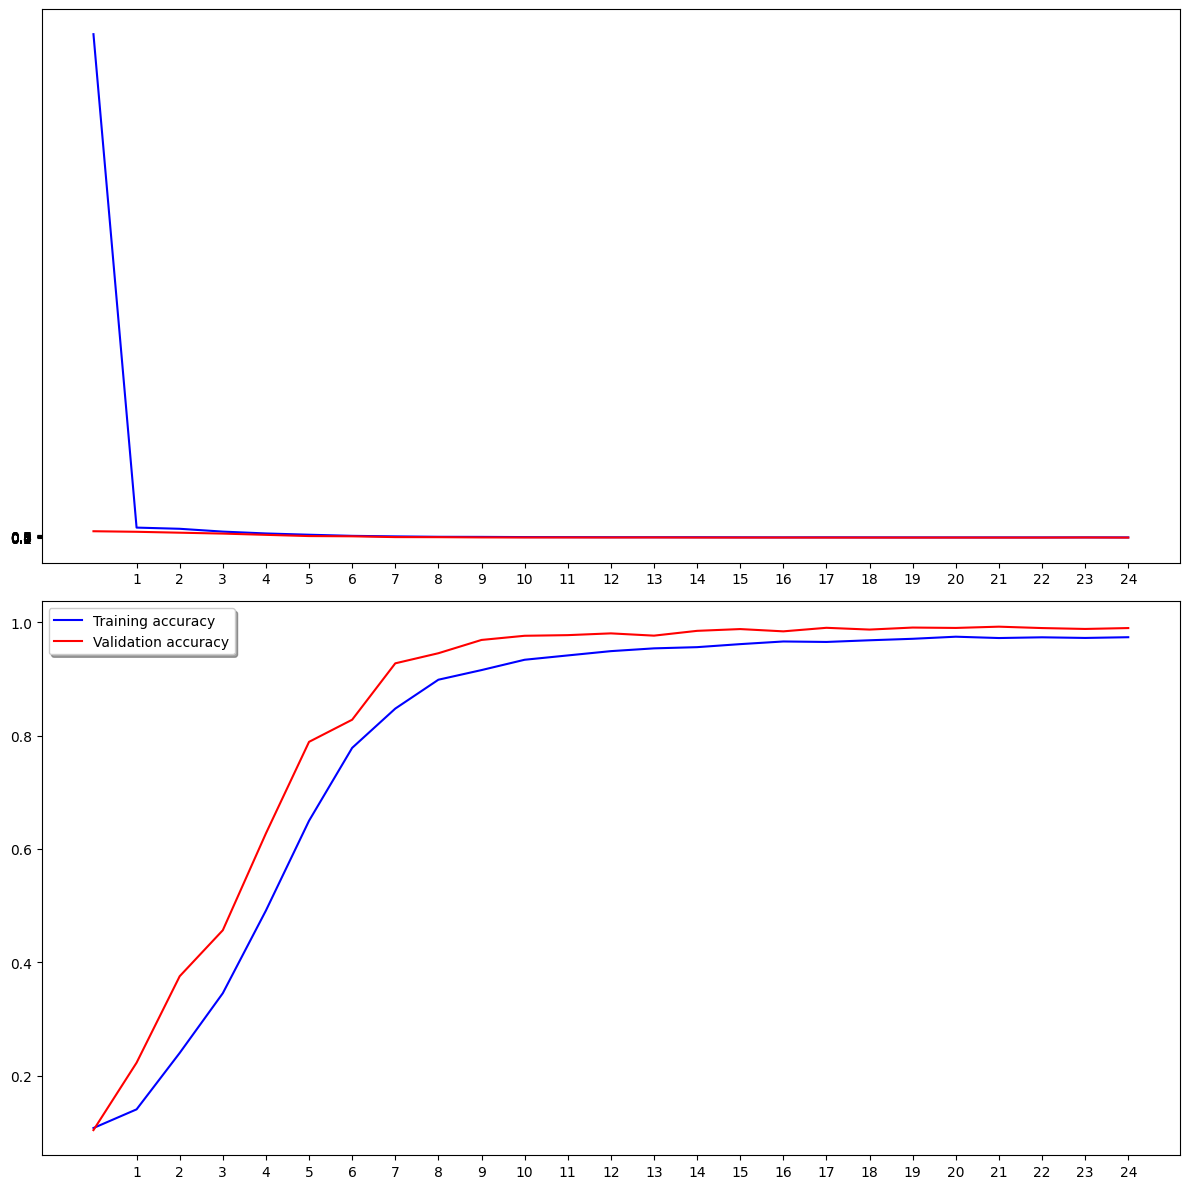

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis

Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created 

In [36]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig


In [37]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels,predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)


In [38]:
ypred = model.predict(valid_data)

valid_list = valid_data.classes.tolist()

ypred_class = np.argmax(ypred,axis=1)
ytest = valid_list

36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 870ms/step


In [39]:
class_names = list()
for name,idx in valid_data.class_indices.items():
    class_names.append(name)
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


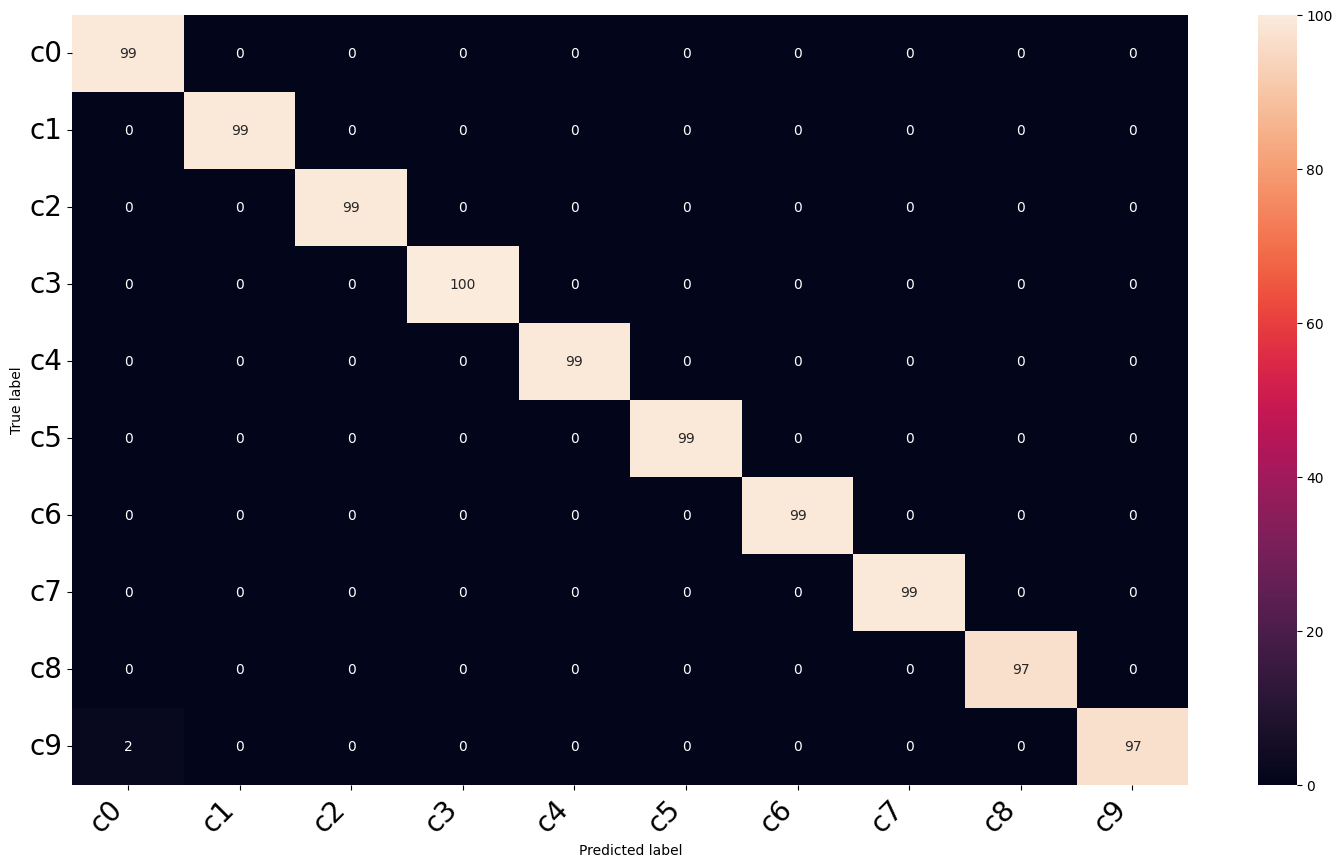

In [40]:
print_heatmap(ytest,ypred,class_names)

## Precision Recall F1 Score

In [41]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.990627
Precision: 0.990698
Recall: 0.990627
F1 score: 0.990626


In [42]:
model.evaluate(valid_data)

36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 882ms/step - accuracy: 0.9941 - loss: 0.0298


[0.040779877454042435, 0.9915197491645813]